In [40]:
# Basic / plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, \
    classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
import seaborn as sns


In [41]:
# Load train & test sets
train_df = pd.read_csv("UNSW_NB15_MODELS/UNSW_NB15_training-set.csv")
test_df  = pd.read_csv("UNSW_NB15_MODELS/UNSW_NB15_testing-set.csv")

train_df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [42]:
train_df.info()
train_df.isnull().sum()
train_df['label'].value_counts()  # check class distribution


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

label
1    119341
0     56000
Name: count, dtype: int64

In [43]:
cat_cols = train_df.select_dtypes(include=['object']).columns.tolist()

for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([train_df[col], test_df[col]], axis=0).astype(str)
    le.fit(combined)
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))


In [44]:
X_train = train_df.drop("label", axis=1)
y_train = train_df["label"]

X_test = test_df.drop("label", axis=1)
y_test = test_df["label"]

X_train.shape, X_test.shape, y_train.shape


((175341, 44), (82332, 44), (175341,))

In [45]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.02, random_state=42)
mask = iso.fit_predict(X_train) == 1
X_train = X_train[mask].reset_index(drop=True)
y_train = y_train[mask].reset_index(drop=True)

print("After outlier removal:", X_train.shape)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


After outlier removal: (171834, 44)


In [46]:
# pip install imbalanced-learn   # uncomment to install if needed


sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

X_train, y_train = X_train_res, y_train_res
print("After SMOTE:", X_train.shape, y_train.value_counts().to_dict())


After SMOTE: (235406, 44) {0: 117703, 1: 117703}


In [47]:
# Identify categorical (now encoded as ints) vs numeric if needed
# If you encoded cat cols above, they are numeric ints; decide to treat all columns as numeric.
numeric_cols = X_train.columns.tolist()

# Preprocessor: scale numeric features (Decision Trees don't need scaling, but it's harmless)
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols)
], remainder='passthrough')

# Decision Tree classifier (tune max_depth, min_samples_leaf)
dt = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_leaf=10)

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', dt)
])


In [48]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("Accuracy: ", round(acc, 4))
print("Precision:", round(prec, 4))
print("Recall:   ", round(rec, 4))
print("F1 score: ", round(f1, 4))



Accuracy:  1.0
Precision: 1.0
Recall:    1.0
F1 score:  1.0


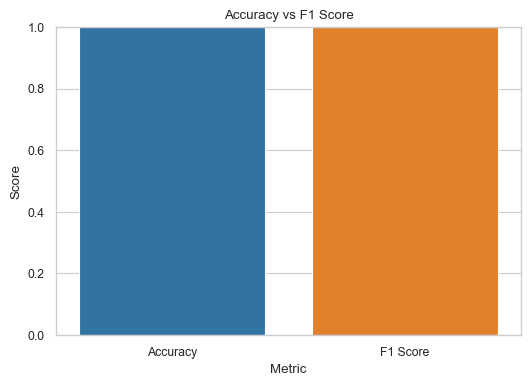

In [49]:
# Apply style
sns.set_style("whitegrid")
sns.set_context("paper")

# Compute metrics
accuracy = accuracy_score(test_df['label'], y_pred)
f1 = f1_score(test_df['label'], y_pred)

# Prepare DataFrame for plotting
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score'],
    'Value': [accuracy, f1]
})

# Plot bar chart
plt.figure(figsize=(6, 4))
sns.barplot(x='Metric', y='Value', data=metrics_df)
plt.title("Accuracy vs F1 Score")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.show()
